Import python libraries required for the script

In [1]:
# Performance metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

#Classifier imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rfpimp import *
from rfpimp import *
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [2]:
# Initialize our classifiers
BNB = BernoulliNB()
GNB = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=1)
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial')
LSVC = LinearSVC(max_iter=2000, tol=0.001)
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, warm_start=True)
MNB = MultinomialNB()
# NSVC = NuSVC(gamma='scale') # need to study about good value for nu
SGD = SGDClassifier(max_iter=1000, tol=0.001)
SVC = SVC(gamma='scale')


ADA = AdaBoostClassifier()
BAG = BaggingClassifier()
XTree = ExtraTreesClassifier(n_estimators=500)
GBC = GradientBoostingClassifier()
RFC = RandomForestClassifier(n_estimators=500)
# Vote = VotingClassifier()

XGB = XGBClassifier(max_depth=5, n_estimators=500)

Read the CSV files

In [3]:
df = pd.read_csv('VMI_Data_BP2_V02_AK6_mod02.csv')
print(df.columns)

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'LFT_SPLICE_LENGTH',
       'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 'BP2_S8_L',
       'BP2_S7_L', 'BP2_S6_L', 'BP2_S5_L', 'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L',
       'BP2_S1_ML', 'BP2_S1_MR', 'BP2_S2_R', 'BP2_S3_R', 'BP2_S4_R',
       'BP2_S5_R', 'BP2_S6_R', 'BP2_S7_R', 'BP2_S8_R', 'BP1_LENGTH',
       'LFT_SPLICE_DELTA', 'LFT_SPLICE_PREV', 'LFT_SPLICE_MA5',
       'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50',
       'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20',
       'LFT_SPLICE_SLOPE50', 'MID_SPLICE_DELTA', 'MID_SPLICE_PREV',
       'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
       'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10',
       'MID_SPLICE_SLOPE20', 'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA',
       'RHT_SPLICE_PREV', 'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10',
       'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5',
       'RHT_SPLICE_SLOPE10', 'RHT_SPLICE_SLOPE20'

In [4]:
df = df.drop(['LFT_SPLICE_LENGTH', 'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 
              'LFT_SPLICE_GRADE', 'MID_SPLICE_GRADE', 'RHT_SPLICE_GRADE', 'LFT_SPLICE_DELTA', 
              'LFT_SPLICE_MA5', 'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50', 
              'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50',
              'MID_SPLICE_DELTA', 'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
              'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10', 'MID_SPLICE_SLOPE20',
              'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA',  'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10', 
              'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
              'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_SLOPE50'], axis=1)

print(df.columns)

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'BP2_S8_L', 'BP2_S7_L', 'BP2_S6_L',
       'BP2_S5_L', 'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L', 'BP2_S1_ML',
       'BP2_S1_MR', 'BP2_S2_R', 'BP2_S3_R', 'BP2_S4_R', 'BP2_S5_R', 'BP2_S6_R',
       'BP2_S7_R', 'BP2_S8_R', 'BP1_LENGTH', 'LFT_SPLICE_PREV',
       'MID_SPLICE_PREV', 'RHT_SPLICE_PREV', 'SPLICE_GRADE'],
      dtype='object')


Check the columns in the data

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))
df = df.dropna()

                Total  Percent
SPLICE_GRADE        0      0.0
BP2_S1_MR           0      0.0
CONV_WAIT_TIME      0      0.0
BP2_S8_L            0      0.0
BP2_S7_L            0      0.0
BP2_S6_L            0      0.0
BP2_S5_L            0      0.0
BP2_S4_L            0      0.0
BP2_S3_L            0      0.0
BP2_S2_L            0      0.0


In [6]:
df[(df['SPLICE_GRADE']=="Good")]=2
df[(df['SPLICE_GRADE']=="OK")]=1
df[(df['SPLICE_GRADE']=="Bad")]=0
# df.head

In [7]:
X = df.drop(['SPLICE_GRADE'], axis=1)
y = df['SPLICE_GRADE']
y = y.astype('int')

Feature ranking 1:
1. feature 7 - 'BP2_S3_L' (0.059957)
2. feature 12 - 'BP2_S3_R' (0.055889)
3. feature 20 - 'MID_SPLICE_PREV' (0.052024)
4. feature 11 - 'BP2_S2_R' (0.051992)
5. feature 15 - 'BP2_S6_R' (0.050004)
6. feature 21 - 'RHT_SPLICE_PREV' (0.049899)
7. feature 9 - 'BP2_S1_ML' (0.047982)
8. feature 16 - 'BP2_S7_R' (0.046057)
9. feature 18 - 'BP1_LENGTH' (0.046043)
10. feature 13 - 'BP2_S4_R' (0.045986)
11. feature 3 - 'BP2_S7_L' (0.044071)
12. feature 1 - 'CONV_WAIT_TIME' (0.044026)
13. feature 2 - 'BP2_S8_L' (0.043988)
14. feature 4 - 'BP2_S6_L' (0.043945)
15. feature 10 - 'BP2_S1_MR' (0.043919)
16. feature 19 - 'LFT_SPLICE_PREV' (0.042043)
17. feature 5 - 'BP2_S5_L' (0.042040)
18. feature 8 - 'BP2_S2_L' (0.041974)
19. feature 6 - 'BP2_S4_L' (0.041891)
20. feature 0 - 'CUT_LENGTH' (0.040000)
21. feature 17 - 'BP2_S8_R' (0.039978)
22. feature 14 - 'BP2_S5_R' (0.026293)


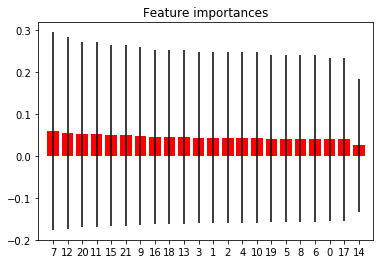

In [8]:
# Training/ Test Split
xx1,xx2,yy1,yy2 =train_test_split(X, y, random_state=0, train_size =0.999, test_size=0.001)

XTree.fit(xx1,yy1)
importances = XTree.feature_importances_
std = np.std([tree.feature_importances_ for tree in XTree.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking 1:")
for f in range(X.shape[1]):
    print("%d. feature %d - '%s' (%f)" % (f + 1, indices[f], df.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

XTree = ExtraTreesClassifier(n_estimators=500)


Feature ranking 2:
1. feature 21 - 'RHT_SPLICE_PREV' (0.049899)
2. feature 16 - 'BP2_S7_R' (0.046057)
3. feature 17 - 'BP2_S8_R' (0.039978)
4. feature 19 - 'LFT_SPLICE_PREV' (0.042043)
5. feature 15 - 'BP2_S6_R' (0.050004)
6. feature 5 - 'BP2_S5_L' (0.042040)
7. feature 18 - 'BP1_LENGTH' (0.046043)
8. feature 1 - 'CONV_WAIT_TIME' (0.044026)
9. feature 0 - 'CUT_LENGTH' (0.040000)
10. feature 8 - 'BP2_S2_L' (0.041974)
11. feature 7 - 'BP2_S3_L' (0.059957)
12. feature 9 - 'BP2_S1_ML' (0.047982)
13. feature 20 - 'MID_SPLICE_PREV' (0.052024)
14. feature 14 - 'BP2_S5_R' (0.026293)
15. feature 2 - 'BP2_S8_L' (0.043988)
16. feature 12 - 'BP2_S3_R' (0.055889)
17. feature 4 - 'BP2_S6_L' (0.043945)
18. feature 13 - 'BP2_S4_R' (0.045986)
19. feature 3 - 'BP2_S7_L' (0.044071)
20. feature 10 - 'BP2_S1_MR' (0.043919)
21. feature 11 - 'BP2_S2_R' (0.051992)
22. feature 6 - 'BP2_S4_L' (0.041891)


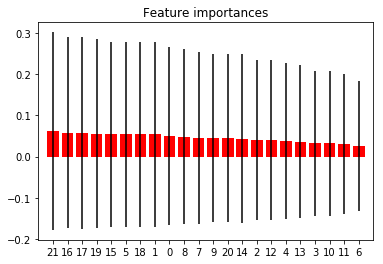

In [9]:
# Training/ Test Split
xx1,xx2,yy1,yy2 =train_test_split(X, y, random_state=0, train_size =0.999, test_size=0.001)

RFC.fit(xx1,yy1)
importances2 = RFC.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
indices2 = np.argsort(importances2)[::-1]

print("Feature ranking 2:")
for f in range(X.shape[1]):
    print("%d. feature %d - '%s' (%f)" % (f + 1, indices2[f], df.columns[indices2[f]], importances[indices2[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances2[indices2], color="r", yerr=std2[indices2], align="center")
plt.xticks(range(X.shape[1]), indices2)
plt.xlim([-1, X.shape[1]])
plt.show()

RFC = RandomForestClassifier(n_estimators=500)

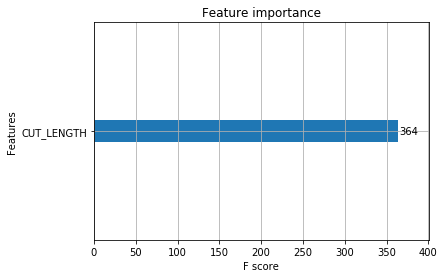

In [10]:
# https://github.com/parrt/random-forest-importances

from rfpimp import *
from rfpimp import *
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.20)

X_train, y_train = df_train.drop('SPLICE_GRADE',axis=1), df_train['SPLICE_GRADE']
X_test, y_test = df_test.drop('SPLICE_GRADE',axis=1), df_test['SPLICE_GRADE']
X_train['random'] = np.random.random(size=len(X_train))
X_test['random'] = np.random.random(size=len(X_test))

# rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
# rf.fit(X_train, y_train)

# imp = importances(rf, X_test, y_test) # permutation
# viz = plot_importances(imp)
# viz.view()

model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()

In [11]:

fold = 1
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x1, x2 = X.iloc[train_index], X.iloc[test_index]
    y1, y2 = y.iloc[train_index], y.iloc[test_index]
    
    print(" ********** FOLD - ", fold, " ********** ")
    # Train our classifier and test predict
    BNB.fit(x1,y1)
    y2_BNB_model = BNB.predict(x2)
    print("BernoulliNB Accuracy :", accuracy_score(y2, y2_BNB_model))

    GNB.fit(x1, y1)
    y2_GNB_model = GNB.predict(x2)
    print("GaussianNB Accuracy :", accuracy_score(y2, y2_GNB_model))

    KNN.fit(x1,y1)
    y2_KNN_model = KNN.predict(x2)
    print("KNeighborsClassifier Accuracy :", accuracy_score(y2, y2_KNN_model))

    LR.fit(x1,y1)
    y2_LR_model = LR.predict(x2)
    print("LogisticRegression Accuracy :", accuracy_score(y2, y2_LR_model))

    LSVC.fit(x1,y1)
    y2_LSVC_model = LSVC.predict(x2)
    print("LinearSVC Accuracy :", accuracy_score(y2, y2_LSVC_model))

    MLP.fit(x1,y1)
    y2_MLP_model = MLP.predict(x2)
    print("MLPClassifier Accuracy :", accuracy_score(y2, y2_MLP_model))
    
    MNB.fit(x1,y1)
    y2_MNB_model = MNB.predict(x2)
    print("MultinomialNB Accuracy :", accuracy_score(y2, y2_MNB_model))
    
#     NSVC.fit(x1,y1)
#     y2_NSVC_model = NSVC.predict(x2)
#     print("NuSVC Accuracy :", accuracy_score(y2, y2_NSVC_model))
    
    SGD.fit(x1,y1)
    y2_SGD_model = SGD.predict(x2)
    print("SGDClassifier Accuracy :", accuracy_score(y2, y2_SGD_model))
    
    SVC.fit(x1,y1)
    y2_SVC_model = SVC.predict(x2)
    print("SVC Accuracy :", accuracy_score(y2, y2_SVC_model))
    
    ADA.fit(x1,y1)
    y2_ADA_model = ADA.predict(x2)
    print("AdaBoostClassifier Accuracy :", accuracy_score(y2, y2_ADA_model))
    
    BAG.fit(x1,y1)
    y2_BAG_model = BAG.predict(x2)
    print("BaggingClassifier Accuracy :", accuracy_score(y2, y2_BAG_model))

    XTree.fit(x1,y1)
    y2_XTree_model = XTree.predict(x2)
    print("ExtraTreesClassifier Accuracy :", accuracy_score(y2, y2_XTree_model))
#     importances = XTree.feature_importances_
#     std = np.std([tree.feature_importances_ for tree in XTree.estimators_], axis=0)
#     indices = np.argsort(importances)[::-1]

    GBC.fit(x1,y1)
    y2_GBC_model = GBC.predict(x2)
    print("GradientBoostingClassifier Accuracy :", accuracy_score(y2, y2_GBC_model))

    RFC.fit(x1,y1)
    y2_RFC_model = RFC.predict(x2)
    print("RandomForestClassifier Accuracy :", accuracy_score(y2, y2_RFC_model))
#     importances2 = RFC.feature_importances_
#     std2 = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
#     indices2 = np.argsort(importances2)[::-1]
    
    XGB.fit(x1,y1)
    y2_XGB_model = XGB.predict(x2)
    print("XGBClassifier Accuracy :", accuracy_score(y2, y2_XGB_model))
    fold += 1

# print("Feature ranking 1:")
# for f in range(X.shape[1]):
#     print("%d. feature %d - '%s' (%f)" % (f + 1, indices[f], df.columns[indices[f]], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()

# print("Feature ranking 2:")
# for f in range(X.shape[1]):
#     print("%d. feature %d - '%s' (%f)" % (f + 1, indices2[f], df.columns[indices2[f]], importances[indices2[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances2[indices2], color="r", yerr=std2[indices2], align="center")
# plt.xticks(range(X.shape[1]), indices2)
# plt.xlim([-1, X.shape[1]])
# plt.show()

 ********** FOLD -  1  ********** 
BernoulliNB Accuracy : 0.9990584207147443
GaussianNB Accuracy : 1.0
KNeighborsClassifier Accuracy : 1.0
LogisticRegression Accuracy : 1.0
LinearSVC Accuracy : 0.9990584207147443
MLPClassifier Accuracy : 0.9990584207147443
MultinomialNB Accuracy : 0.8207575433340466
SGDClassifier Accuracy : 0.9990584207147443
SVC Accuracy : 1.0
AdaBoostClassifier Accuracy : 1.0
BaggingClassifier Accuracy : 1.0
ExtraTreesClassifier Accuracy : 1.0
GradientBoostingClassifier Accuracy : 1.0
RandomForestClassifier Accuracy : 1.0
XGBClassifier Accuracy : 1.0
 ********** FOLD -  2  ********** 
BernoulliNB Accuracy : 0.9990583804143126
GaussianNB Accuracy : 1.0
KNeighborsClassifier Accuracy : 1.0
LogisticRegression Accuracy : 1.0
LinearSVC Accuracy : 0.9990583804143126
MLPClassifier Accuracy : 0.9990583804143126
MultinomialNB Accuracy : 0.8255007704160247
SGDClassifier Accuracy : 0.9990583804143126
SVC Accuracy : 1.0
AdaBoostClassifier Accuracy : 1.0
BaggingClassifier Accuracy

In [12]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# https://explained.ai/rf-importance/

# # use feature importance for feature selection
# from numpy import loadtxt
# from numpy import sort
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import SelectFromModel
# # load data
# dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# # split data into X and y
# X = dataset[:,0:8]
# Y = dataset[:,8]
# # split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# # fit model on all training data
# model = XGBClassifier()
# model.fit(X_train, y_train)
# # make predictions for test data and evaluate
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# # Fit model using each importance as a threshold
# thresholds = sort(model.feature_importances_)
# for thresh in thresholds:
# 	# select features using threshold
# 	selection = SelectFromModel(model, threshold=thresh, prefit=True)
# 	select_X_train = selection.transform(X_train)
# 	# train model
# 	selection_model = XGBClassifier()
# 	selection_model.fit(select_X_train, y_train)
# 	# eval model
# 	select_X_test = selection.transform(X_test)
# 	y_pred = selection_model.predict(select_X_test)
# 	predictions = [round(value) for value in y_pred]
# 	accuracy = accuracy_score(y_test, predictions)
# 	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [13]:
target_names = ['Bad', 'OK', 'Good']
class_names = target_names

In [14]:
print(" *********** GaussianNB *********** ")
print(classification_report(y2, y2_GNB_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** KNeighborsClassifier *********** ")
print(classification_report(y2, y2_KNN_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** LogisticRegression *********** ")
print(classification_report(y2, y2_LR_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** SVC *********** ")
print(classification_report(y2, y2_SVC_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** AdaBoostClassifier *********** ")
print(classification_report(y2, y2_ADA_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** BaggingClassifier *********** ")
print(classification_report(y2, y2_BAG_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** ExtraTreesClassifier *********** ")
print(classification_report(y2, y2_XTree_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** GradientBoostingClassifier *********** ")
print(classification_report(y2, y2_GBC_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** RandomForestClassifier *********** ")
print(classification_report(y2, y2_RFC_model, target_names=target_names, sample_weight=None, digits=4))


 *********** GaussianNB *********** 
              precision    recall  f1-score   support

         Bad     1.0000    1.0000    1.0000      4129
          OK     1.0000    1.0000    1.0000     19217
        Good     1.0000    1.0000    1.0000        18

   micro avg     1.0000    1.0000    1.0000     23364
   macro avg     1.0000    1.0000    1.0000     23364
weighted avg     1.0000    1.0000    1.0000     23364

 *********** KNeighborsClassifier *********** 
              precision    recall  f1-score   support

         Bad     1.0000    1.0000    1.0000      4129
          OK     1.0000    1.0000    1.0000     19217
        Good     1.0000    1.0000    1.0000        18

   micro avg     1.0000    1.0000    1.0000     23364
   macro avg     1.0000    1.0000    1.0000     23364
weighted avg     1.0000    1.0000    1.0000     23364

 *********** LogisticRegression *********** 
              precision    recall  f1-score   support

         Bad     1.0000    1.0000    1.0000      4129


In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 4129     0     0]
 [    0 19217     0]
 [    0     0    18]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


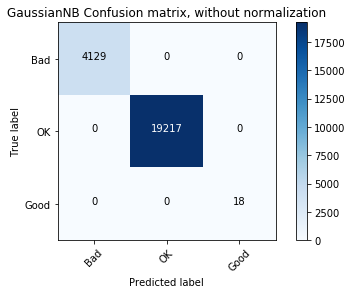

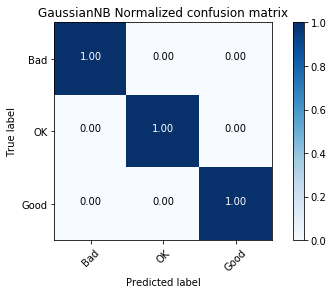

In [16]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2, y2_GNB_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='GaussianNB Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='GaussianNB Normalized confusion matrix')

plt.show();

Confusion matrix, without normalization
[[ 4129     0     0]
 [    0 19217     0]
 [    0     0    18]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


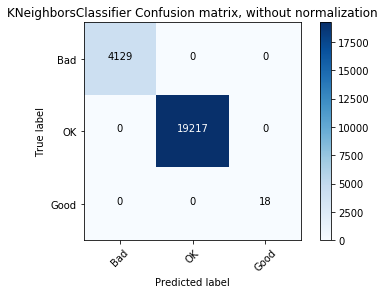

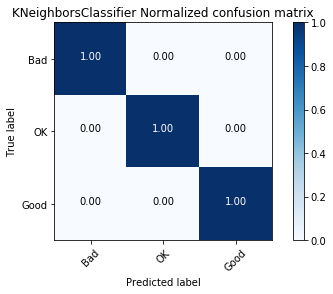

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2, y2_KNN_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='KNeighborsClassifier Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='KNeighborsClassifier Normalized confusion matrix')

plt.show();

Confusion matrix, without normalization
[[ 4129     0     0]
 [    0 19217     0]
 [    0     0    18]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


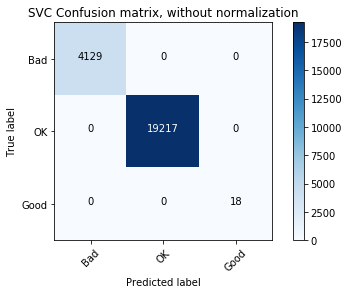

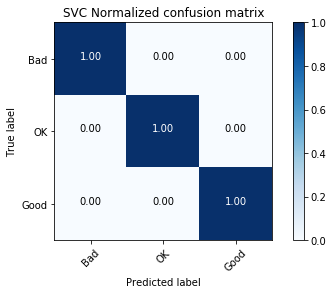

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2, y2_SVC_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='SVC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='SVC Normalized confusion matrix')

plt.show();

In [19]:
# Try out these
# sklearn.multioutput.MultiOutputClassifier
# sklearn.multiclass.OutputCodeClassifier
# sklearn.multiclass.OneVsOneClassifier
# sklearn.multiclass.OneVsRestClassifier
# sklearn.model_selection.RandomizedSearchCV -- https://stackoverflow.com/questions/52029408/sklearn-mlp-classifier-hyperparameter-optimization-randomizedsearchcv
# sklearn.model_selection.check_cv
# sklearn.model_selection.StratifiedKFold
# sklearn.linear_model.RidgeClassifierCV
# sklearn.linear_model.PassiveAggressiveClassifier
# sklearn.linear_model.LogisticRegressionCV
# sklearn.gaussian_process.GaussianProcessClassifier
# sklearn.tree.DecisionTreeClassifier
# sklearn.tree.ExtraTreeClassifier
# Feature significance
# Narrow to Wide Splice
# Prev Deltas MA & Slope
